![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest parameter optimization
</b>
</span>

---
**Notebook version**: `1` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch) 

</br>

# **Background**

- Finding optimal model parameters

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import importlib.metadata
from datetime import datetime
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.gapfilling.randomforest_ts import OptimizeParamsRFTS
import matplotlib.pyplot as plt
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.74.0


</br>

# **Docstring** for `RandomForestTS`

In [3]:
help(OptimizeParamsRFTS)

Help on class OptimizeParamsRFTS in module diive.pkgs.gapfilling.randomforest_ts:

class OptimizeParamsRFTS(builtins.object)
 |  OptimizeParamsRFTS(df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |  
 |  Optimize parameters for random forest model
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |      Args:
 |          df: dataframe of target and predictor time series
 |          target_col: name of target in *df*, all variables that are not *target* are
 |              used as predictors
 |          **rf_params: dict of parameters for random forest model, where parameter ranges are
 |              provided as lists, e.g.
 |                  rf_params = {
 |                      'n_estimators': list(range(2, 12, 2)),
 |                      'criterion': ['squared_error'],
 |                      'max_depth': [None],
 |                      'min_samples_split': list(range(2, 12, 2)),
 |   

</br>

# **Load data**

## Load example data from parquet file

In [4]:
df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.051 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
subset = df[subsetcols].copy()
_subset = df.index.year == 2019
subset = subset[_subset].copy()
subset

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
TIMESTAMP_MIDDLE,,,,
2019-01-01 00:15:00,NaN,-3.380,0.274,0.0
2019-01-01 00:45:00,NaN,-3.357,0.331,0.0
2019-01-01 01:15:00,NaN,-3.607,0.258,0.0
2019-01-01 01:45:00,-3.144,-3.890,0.244,0.0
2019-01-01 02:15:00,NaN,-4.003,0.339,0.0
...,...,...,...,...
2019-12-31 21:45:00,NaN,-2.440,1.587,0.0
2019-12-31 22:15:00,NaN,-2.447,1.591,0.0
2019-12-31 22:45:00,NaN,-2.455,1.594,0.0


In [6]:
subset.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,6352.000000,17520.000000,17520.000000,17520.000000
mean,-3.227767,4.783583,3.357885,150.497459
std,6.368514,7.797762,4.127673,246.515514
min,-37.557000,-15.450000,0.000000,0.000000
25%,-7.362500,-1.097000,0.661000,0.000000
50%,-2.594000,4.343000,1.912500,2.494000
75%,1.047000,10.377000,4.415000,213.924500
max,23.234000,28.713000,32.118000,1144.630000


In [7]:
sstats(subset[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2019-01-01 00:15
ENDDATE,2019-12-31 23:45
PERIOD,364 days 23:30:00
NOV,6352
MISSING,11168
MISSING_PERC,63.744292
MEAN,-3.227767
SD,6.368514
VAR,40.557976
SD/MEAN,-1.973041


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


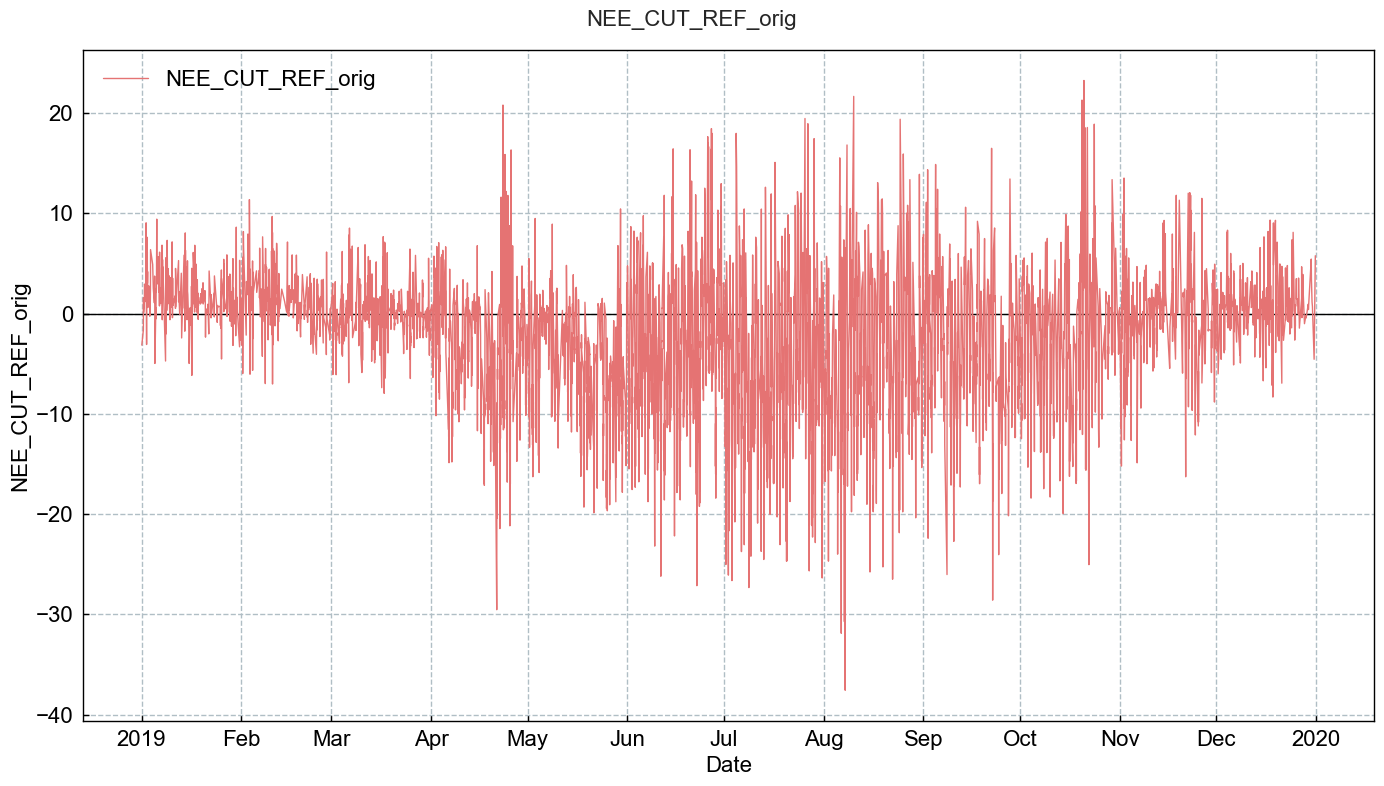

In [8]:
# TimeSeries(series=subset[TARGET_COL]).plot_interactive()
TimeSeries(series=subset[TARGET_COL]).plot()

</br>

</br>

# **Parameter optimization**

## Initialize

In [9]:
# Random forest parameters
rf_params = {
    'n_estimators': list(range(5, 55, 5)),
    'criterion': ['squared_error'],
    'max_depth': [None],
    'min_samples_split': list(range(2, 12, 2)),
    'min_samples_leaf': list(range(1, 6, 1))
}

# Optimization
opt = OptimizeParamsRFTS(
    df=subset,
    target_col=TARGET_COL,
    **rf_params
)

</br>

## Optimize parameters

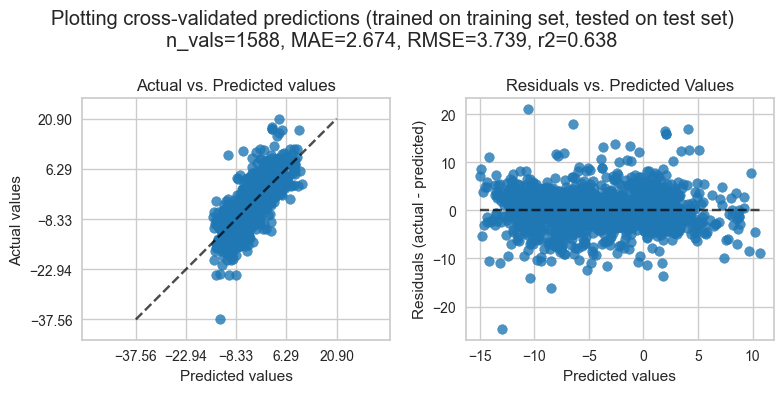

In [10]:
opt.optimize()

</br>

## Result

In [11]:
# Estimator which gave highest score (or smallest loss if specified) on the left out data
opt.best_params

{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 40}

In [12]:
# Return model scores for best model
opt.scores

{'mae': 2.673603796642478,
 'medae': 1.9575714705851759,
 'mse': 13.98241201849317,
 'rmse': 3.7393063552607146,
 'mape': 1.9463676125707925,
 'maxe': 24.6234125995267,
 'r2': 0.6377996385639442}

In [13]:
# Cross-validation results
opt.cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,...,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132187,0.070306,0.001700,0.000455,squared_error,None,...,-19.782895,-20.630577,-16.064681,-20.568675,1.857802,250
1,0.289407,0.138953,0.002097,0.000372,squared_error,None,...,-17.753414,-18.226369,-15.826808,-18.865516,1.649043,245
2,0.424219,0.264779,0.003095,0.000536,squared_error,None,...,-17.682260,-18.605682,-14.763843,-18.287547,1.798933,230
3,0.600270,0.372077,0.003690,0.000779,squared_error,None,...,-16.501024,-18.361877,-14.466693,-18.123120,1.840315,223
4,0.696997,0.356525,0.005238,0.002650,squared_error,None,...,-16.111578,-18.583535,-14.437211,-18.101185,1.801667,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.706088,0.370221,0.007580,0.007492,squared_error,None,...,-15.441893,-16.343442,-13.804878,-16.705014,1.468121,9
246,0.723090,0.426530,0.005087,0.000698,squared_error,None,...,-15.099579,-16.310277,-14.006233,-16.764738,1.449858,26
247,0.819689,0.412754,0.007282,0.001895,squared_error,None,...,-15.471798,-16.379679,-13.941476,-16.815126,1.523857,40
248,0.990071,0.498075,0.006383,0.000798,squared_error,None,...,-15.161447,-16.459119,-13.885866,-16.696327,1.533546,7


In [14]:
# Mean cross-validated score of the best_estimator
opt.best_score

-16.574766267272857

In [15]:
# The number of cross-validation splits (folds/iterations)
opt.cv_n_splits

10

</br>

## Plot

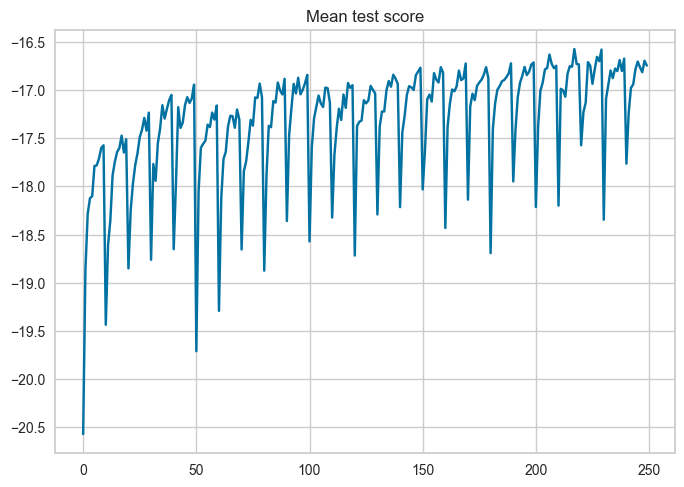

In [16]:
opt.cv_results['mean_test_score'].plot(title="Mean test score");

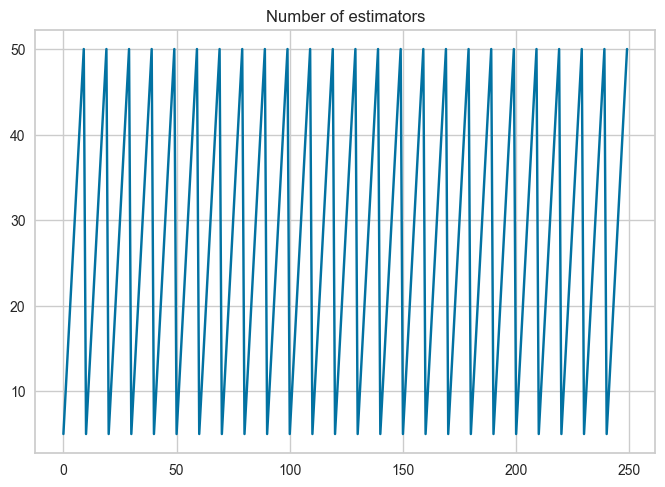

In [17]:
opt.cv_results['param_n_estimators'].plot(title="Number of estimators");

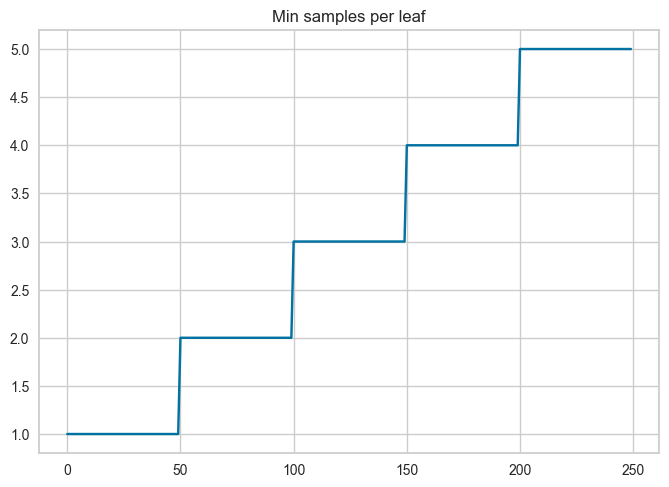

In [18]:
opt.cv_results['param_min_samples_leaf'].plot(title="Min samples per leaf");

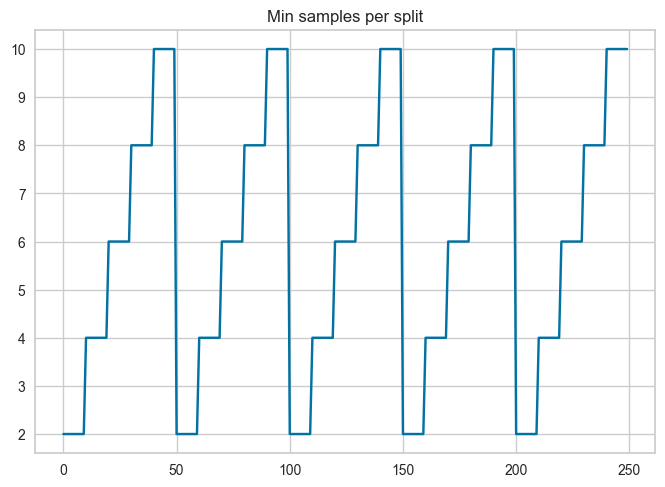

In [19]:
opt.cv_results['param_min_samples_split'].plot(title="Min samples per split");

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [20]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-20 18:54:34
